In [4]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

target_image_size = 256

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [5]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cpu')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("/mas/u/asma_gh/DALL-E/download/encoder.pkl", dev)
dec = load_model("/mas/u/asma_gh/DALL-E/download/decoder.pkl", dev)

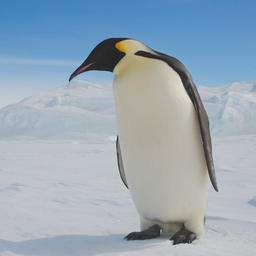

In [6]:
x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

In [9]:
z_logits

tensor([[[[100.4651, 124.5199, 112.5127,  ..., 120.8782, 109.3482,  90.6609],
          [128.2020, 140.4173, 154.4885,  ..., 112.0102, 124.7916,  92.2818],
          [144.8904, 198.4193, 188.5030,  ..., 106.9978, 171.0194, 117.4445],
          ...,
          [154.8568, 208.7154, 131.9131,  ...,  71.5485,  63.4689,  83.3457],
          [ 86.1838,  85.4888,  75.5493,  ..., 156.2557, 125.3903, 146.7929],
          [140.8075, 180.3522, 100.8144,  ..., 140.3664, 153.7763, 111.8179]],

         [[158.4515, 147.7640, 148.6357,  ..., 135.2269, 135.0330, 120.0185],
          [146.0019, 149.2418, 164.0634,  ..., 137.5882, 135.7684, 129.7205],
          [144.6349, 163.4693, 177.5672,  ..., 141.8018, 163.4959, 139.8840],
          ...,
          [ 97.1915, 125.4343,  69.5885,  ...,  66.1259,  53.2863,  62.3291],
          [140.2822, 147.0549, 133.7590,  ...,  93.2322,  64.2244,  68.9730],
          [ 68.8368,  83.0822,  96.9886,  ...,  85.7208, 108.8834,  72.2374]],

         [[233.4471, 255.0416,

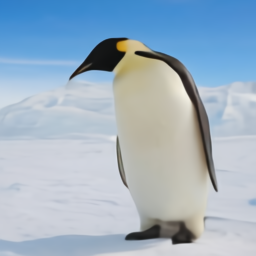

In [7]:
import torch.nn.functional as F

z_logits = enc(x)
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)